In [ ]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image, ImageDraw
import numpy as np
from matplotlib import pyplot as plt
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='id', det_model_dir='./app/Models/en_PP-OCRv3_det_infer', rec_model_dir='./app/Models/latin_PP-OCRv3_rec_infer', cls_model_dir='./app/Models/ch_ppocr_mobile_v2.0_cls_infer', use_space_char=True) # need to run only once to download and load model into memory

[2024/12/03 20:47:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='./Models/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='./Models/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='C:\\Users\\RYZEN 5\\

[2024/12/04 12:42:15] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.9979968070983887
[2024/12/04 12:42:15] ppocr DEBUG: cls num  : 24, elapsed : 0.20999956130981445
[2024/12/04 12:42:16] ppocr DEBUG: rec_res num  : 24, elapsed : 1.592998743057251


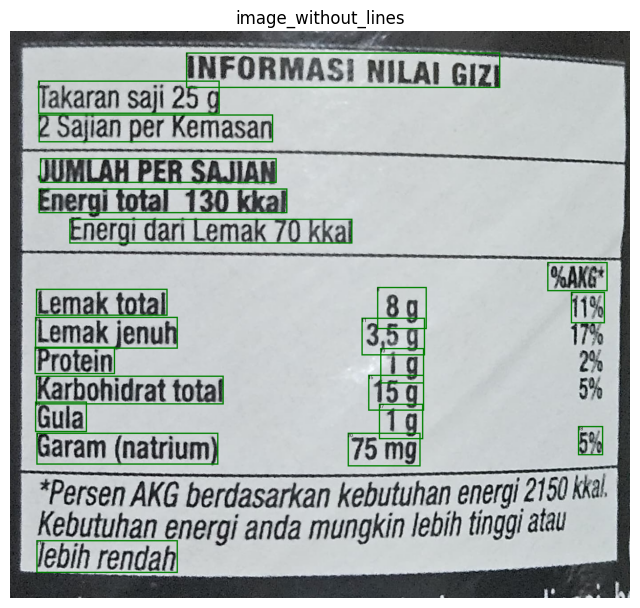

In [116]:
img_path = './testing_img/IMG-20240528-WA0030_cropped.jpg'
result = ocr.ocr(img_path, cls=True)

# draw result
result = result[0]
image = Image.open(img_path).convert('RGB')
draw = ImageDraw.Draw(image)
for j, box in enumerate(result):
    box = np.array(box[0]).astype(np.int32)
    xmin = min(box[:, 0])
    ymin = min(box[:, 1])
    xmax = max(box[:, 0])
    ymax = max(box[:, 1])
    draw.rectangle((xmin, ymin, xmax, ymax), outline="green", width=3)
    draw.text((xmin, ymin), f"{j}", fill="black")
    
plt.figure(figsize=(8, 8))  # Set the figure size
plt.imshow(image)
plt.axis('off')  # Hide axes for cleaner visualization
plt.title("image_without_lines")
plt.show()

In [ ]:
import re

nutrition_keyword_units = {
    'serving_size': (['takaran saji', 'takaransaji', 'ukuran sajian', 'ukuransajian'], ['g']),
    'calories': (['energi total', 'total energi', 'energy total', 'total energy', 'calories', 'energi', 'energy'], ['kkal', 'kcal', 'kj']),
    'protein': (['protein'], ['g']),
    'fat': (['lemak jenuh', 'lemakjenuh', 'saturated fat', 'saturatedfat'], ['g']),
    'sugar': (['gula', 'sugar'], ['g']),
    'total_carbohydrate': (['karbohidrat total', 'karbohidrattotal', 'total karbohidrat', 'totalkarbohidrat', 'total carbohydrate'], ['g']),
    'fiber': (['serat', 'serat pangan', 'dietary fiber'], ['g']),
    'natrium': (['(natrium)', 'garam', 'salt', 'sodium'], ['mg', 'g'])
}

nutrition_value_units = {}

for i, keywords in nutrition_keyword_units.items():
    is_found = False
    for keyword in keywords[0]:
        for j, line in enumerate(result):
            line[1] = (line[1][0].lower(), line[1][1])
            # if 'takaran saji' in line[1][0]:
            #     value = re.search(r'\D*(\d+,?\d*)\s?m?g?', line[1][0]).group(1)
            #     print(line[1][0], value)
            
            if not keyword in line[1][0]: continue
            
            value = None
            founded_unit = ''
            
            for unit in keywords[1]:
                value = re.search(r'\D*'+ re.escape(keyword) +r'\s?(\d+,?\.?\d*)[\s]?'+re.escape(unit), line[1][0])
                if not value:
                    value = re.search(r'(\d+,?\.?\d*)[\s]?'+re.escape(unit), result[j+1][1][0])
                    if not value:
                        value = re.search(r'(\d+,?\.?\d*)[\s]?'+re.escape(unit), result[j-1][1][0])
                        if not value:
                            # print(line[1][0])
                            continue
                # print(keyword, unit, value.group(1))
                
                founded_unit = unit
                break
            if not value: continue
            
            # print(line[1][0], f'\tKeyword:{keyword}\tRESULT:', value.group(1))
            nutrition_value_units.update({i: [float(value.group(1).replace(',', '.')), founded_unit]})
            is_found = True
            break
        if is_found: break
    if is_found: continue
    nutrition_value_units.update({i: [0.0, '']})
    
nutrition_value_units

{'serving_size': [25.0, 'g'],
 'calories': [130.0, 'kkal'],
 'protein': [1.0, 'g'],
 'fat': [3.5, 'g'],
 'sugar': [1.0, 'g'],
 'total_carbohydrate': [15.0, 'g'],
 'fiber': [0.0, ''],
 'natrium': [75.0, 'mg']}

In [171]:
scaled_nutrition = 100/nutrition_value_units['serving_size'][0]

all_nutrition_value = {}

for nutrition, value in nutrition_value_units.items():
    if nutrition == 'calories' and (value[1]=='kkal' or value[1]=='kcal'):
        all_nutrition_value[nutrition] = round(value[0]*4.184, 3)*scaled_nutrition
    elif value[1]=='mg':
        all_nutrition_value[nutrition] = (value[0]/1000)*scaled_nutrition
    elif value[1]=='':
        if nutrition == 'fiber' and 'total_carbohydrate' in nutrition_value_units and 'sugar' in nutrition_value_units:
            all_nutrition_value[nutrition] = (nutrition_value_units['total_carbohydrate'][0] - nutrition_value_units['sugar'][0])*scaled_nutrition
        else: all_nutrition_value[nutrition] = value[0]*scaled_nutrition
    else: all_nutrition_value[nutrition] = value[0]*scaled_nutrition

negative_quantization = {
    'calories': [335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350],
    'sugar': [3.4, 6.8, 10, 14, 17, 20, 24, 27, 31, 34, 37, 41, 44, 48, 51],
    'fat': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'natrium': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]
}

positive_quatization = {
    'fiber': [3.0, 4.1, 5.2, 6.3, 7.4],
    'protein': [2.4, 4.8, 7.2, 9.6, 12, 14, 17]
}

nutrition_value = {
    'vegetable': 0.0
}

nutri_score = 0

for nutrition, value in all_nutrition_value.items():
    if nutrition in negative_quantization:
        nutrition_value.update({nutrition:value})
        for i, limit in enumerate(negative_quantization[nutrition]):
            if value <= limit:
                nutri_score += i
                break
            elif i == len(negative_quantization[nutrition])-1: nutri_score += i+1
    if nutrition in positive_quatization:
        nutrition_value.update({nutrition:value})
        for i, limit in enumerate(positive_quatization[nutrition]):
            if value <= limit:
                nutri_score -= i
                break
            elif i == len(positive_quatization[nutrition])-1: nutri_score -= i+1
            
nutrition_value.update({'nutriscore': nutri_score})

nutri_grade_class = {
    'A': 0,
    'B': 2,
    'C': 10,
    'D': 18,
    'E': 19,
}

nutri_grade = ''

for grade, limit in nutri_grade_class.items():
    if nutri_score <= limit:
        nutri_grade = grade
        break
    elif grade == 'E': nutri_score = grade
    
nutrition_value.update({'grade': nutri_grade})

In [172]:
nutrition_value

{'vegetable': 0.0,
 'calories': 2175.68,
 'protein': 4.0,
 'fat': 14.0,
 'sugar': 4.0,
 'fiber': 56.0,
 'natrium': 0.3,
 'nutriscore': 12,
 'grade': 'D'}